
# 小地域の収入推定

```Data```フォルダには、小地域の収入データ(```income_district.csv```)と国勢調査の小地域集計データが格納されています。

国勢調査の小地域集計データ（人口構成、労働力構成、住宅形態など）から、その地域の収入を推定することが考えられます。推定のための機械学習・深層学習モデルを構築しなさい。


- データを観察・理解する上で、データの構造を説明しながら、適切なデータ整形を行いなさい
- データ構造や分析結果に対して、少なくとも二つの図で可視化を行いなさい
- モデルの精度を評価し、できるだけ精度が高いモデルを得るよう、適切な特徴量エンジニアリングやモデル選定の考えもまとめなさい


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from functools import reduce
import japanize_matplotlib
import os

In [ ]:
# -データを観察・理解する上で、データの構造を説明しながら、適切なデータ整形を行いなさい

#データの読み込み
os.chdir(r'C:\Users\jiang\OneDrive\デスクトップ\行動科学\5セメ\演習（呂）\データ')

dataframes_census = {
    'age': pd.read_csv('h27_age_df.csv'),
    'family': pd.read_csv('h27_family_df.csv'),
    'gender': pd.read_csv('h27_gender_df2.csv'),
    'house': pd.read_csv('h27_house_df.csv'),
    'house_info': pd.read_csv('h27_house_info_df.csv'),
    'industry': pd.read_csv('h27_indusry_df.csv'),
    'job': pd.read_csv('h27_job_df.csv'),
    'labor': pd.read_csv('h27_labor_df.csv'),
    'marriage': pd.read_csv('h27_marriage_df.csv'),
    'work_status': pd.read_csv('h27_work_status_df.csv')
}
df_income = pd.read_csv('income_district.csv')


#データ結合と整形
##dataframes_censusに共通したキーは以下の7つなのでそれを基に結合する
key_columns = [
    'district_id', 'district2_id', 'level_identifier', 
    'state_name', 'city_name', 'district_name', 'district2_name'
]
df_census_merged = reduce(lambda left, right: pd.merge(left, right, on=key_columns, how='outer'), dataframes_census.values())

##df_incomeはdataframes_censusと共通したキーがないのでarea_codeをdistrict_idに変更し、結合する
df_income.rename(columns={'area_code': 'district_id'}, inplace=True)
final_df = pd.merge(df_census_merged, df_income, on='district_id', how='left')

##欠損値への対処、文字列を数値に変換、重複変数の除去を実行
final_df.dropna(subset=['income_mean'], inplace=True)

numeric_cols_to_convert = final_df.columns.drop(key_columns + ['income_mean'], errors='ignore')
for col in numeric_cols_to_convert:
    if final_df[col].dtype == 'object':
        final_df[col] = pd.to_numeric(final_df[col], errors='coerce')

final_df.fillna(0, inplace=True)

if 'family_count_y' in final_df.columns:
    final_df.drop('family_count_y', axis=1, inplace=True)
    final_df.rename(columns={'family_count_x': 'family_count'}, inplace=True)


In [ ]:
# -データ構造や分析結果に対して、少なくとも二つの図で可視化を行いなさい
#データの可視化
sns.set(style='whitegrid')

#可視化1: 散布図
plt.figure(figsize=(10, 6))
sns.regplot(data=final_df, x='40-44', y='income_mean', 
            scatter_kws={'alpha':0.3, 'color':'blue'}, line_kws={'color':'red'})
plt.title('地区平均収入と40-44歳人口の関係', fontsize=16)
plt.xlabel('40-44歳 人口（人）', fontsize=12)
plt.ylabel('地区平均収入（万円）', fontsize=12)
plt.ticklabel_format(style='plain', axis='y')
plt.grid(True)
plt.show()

#可視化2: ヒストグラム
plt.figure(figsize=(10, 6))
income_unique = final_df[['district_id', 'income_mean']].drop_duplicates()
sns.histplot(income_unique['income_mean'], kde=True, bins=30, color='green')
plt.title('地区ごとの平均収入の分布', fontsize=16)
plt.xlabel('平均収入（万円）', fontsize=12)
plt.ylabel('地区の数', fontsize=12)
plt.grid(True)
plt.show()

c:\Users\jiang\anaconda3\anaconda\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 27507 (\N{CJK UNIFIED IDEOGRAPH-6B73}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\jiang\anaconda3\anaconda\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 20154 (\N{CJK UNIFIED IDEOGRAPH-4EBA}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\jiang\anaconda3\anaconda\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 21475 (\N{CJK UNIFIED IDEOGRAPH-53E3}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\jiang\anaconda3\anaconda\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 65288 (\N{FULLWIDTH LEFT PARENTHESIS}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\jiang\anaconda3\anaconda\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 65289 (\N{FULLWIDTH RIGHT PARENTHESIS}) missing f

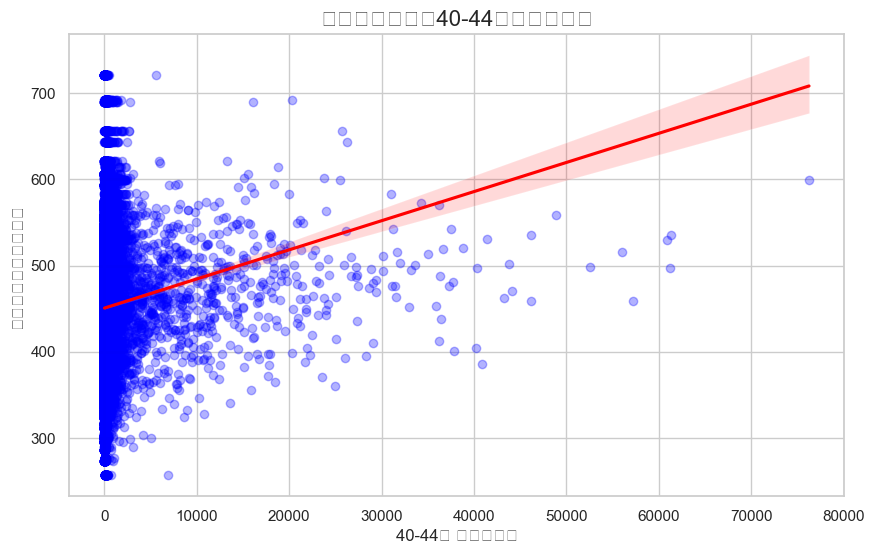

c:\Users\jiang\anaconda3\anaconda\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 24179 (\N{CJK UNIFIED IDEOGRAPH-5E73}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\jiang\anaconda3\anaconda\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 22343 (\N{CJK UNIFIED IDEOGRAPH-5747}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\jiang\anaconda3\anaconda\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 21454 (\N{CJK UNIFIED IDEOGRAPH-53CE}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\jiang\anaconda3\anaconda\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 20837 (\N{CJK UNIFIED IDEOGRAPH-5165}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\jiang\anaconda3\anaconda\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 65288 (\N{FULLWIDTH LEFT PARENTHESIS}) missing fr

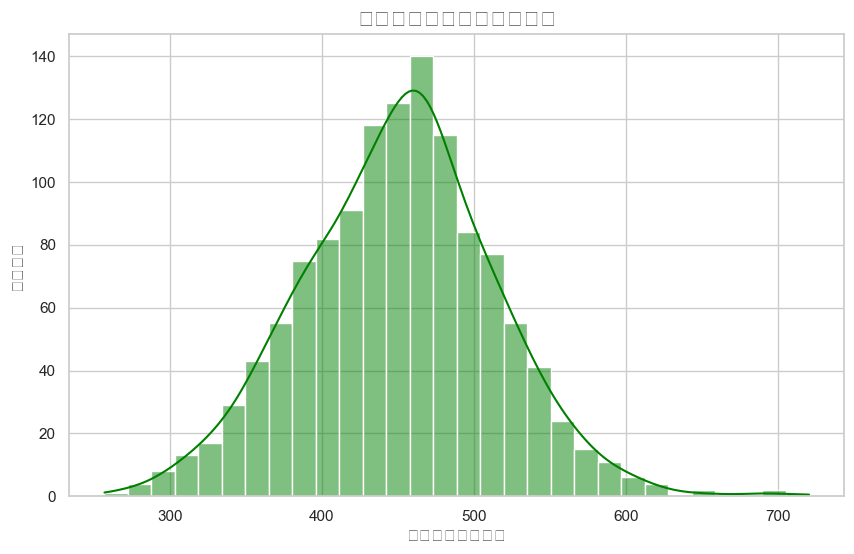

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.295679 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 46159
[LightGBM] [Info] Number of data points in the train set: 182609, number of used features: 188
[LightGBM] [Info] Start training from score 451.171005
テストデータでのRMSE: 41.61


C:\Users\jiang\AppData\Local\Temp\ipykernel_14276\4113489936.py:113: UserWarning: Glyph 37325 (\N{CJK UNIFIED IDEOGRAPH-91CD}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\jiang\AppData\Local\Temp\ipykernel_14276\4113489936.py:113: UserWarning: Glyph 35201 (\N{CJK UNIFIED IDEOGRAPH-8981}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\jiang\AppData\Local\Temp\ipykernel_14276\4113489936.py:113: UserWarning: Glyph 24230 (\N{CJK UNIFIED IDEOGRAPH-5EA6}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\jiang\AppData\Local\Temp\ipykernel_14276\4113489936.py:113: UserWarning: Glyph 29305 (\N{CJK UNIFIED IDEOGRAPH-7279}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\jiang\AppData\Local\Temp\ipykernel_14276\4113489936.py:113: UserWarning: Glyph 24500 (\N{CJK UNIFIED IDEOGRAPH-5FB4}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\jiang\AppData\Local\Temp\ipykernel_14276\4113489936.py:113: UserWarning: Glyph 37327 (\N{CJK UNIFIED IDEOGRAPH-

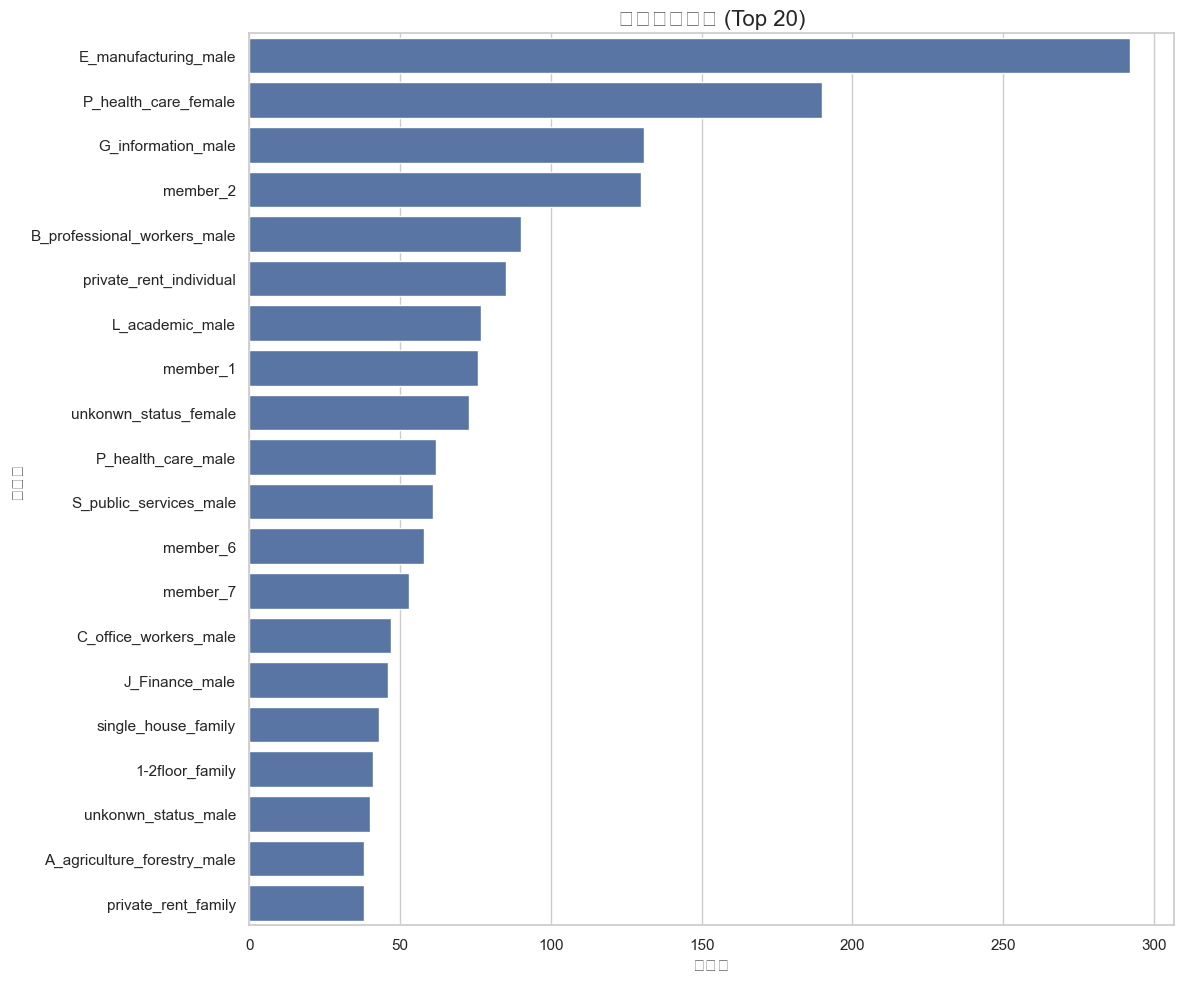

In [ ]:
#- モデルの精度を評価し、できるだけ精度が高いモデルを得るよう、適切な特徴量エンジニアリングやモデル選定の考えもまとめなさい
##特徴量エンジニアリングは相関が低い、または情報量が少ない特徴量や、欠損値を処理し、新しい適切な特徴量を作成するなどして、モデルの精度を高めたり、理解が容易なモデルにすることが目的である。
##モデル選定は複数のモデルを比較することで、過学習などの問題を防止し、予測精度を最大化する方法である

#特徴量とターゲットを定義
target_column = 'income_mean'
features_to_drop = [col for col in key_columns if col in final_df.columns]
X = final_df.drop(columns=features_to_drop + [target_column])
y = final_df[target_column]

#データを訓練用とテスト用に分割
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#LightGBMモデルの学習
model = lgb.LGBMRegressor(random_state=42)
model.fit(X_train, y_train)

#予測と評価
predictions = model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, predictions))
print(f"テストデータでのRMSE: {rmse:.2f}")


#特徴量重要度の可視化
feature_importance_df = pd.DataFrame({
    'feature': X_train.columns,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=False)

top_features = feature_importance_df.head(20)

plt.figure(figsize=(12, 10))
sns.barplot(x='importance', y='feature', data=top_features)
plt.title('特徴量重要度 (Top 20)', fontsize=16)
plt.xlabel('重要度', fontsize=12)
plt.ylabel('特徴量', fontsize=12)
plt.tight_layout()
plt.show()